Entrenamiento de Modelo LSTM para Predicción de Temperatura
Usando 3 features del dataset meteorológico
Este notebook entrena un modelo LSTM usando solo 4 columnas del dataset_ml.csv:

Features seleccionadas:

ts: Temperatura del Aire Seco (°C) → [OBJETIVO A PREDECIR]
hr: Humedad Relativa del aire (%)
p0: Presión leída del sensor (hPa)
Tambien utilizar momento a lo que se refiere a la hora
Este enfoque simplificado permite:

✅ Entrenamiento más rápido
✅ Modelo más ligero
✅ Fácil de mapear con datos de Arduino (temperatura, humedad, presión)
✅ Menos riesgo de overfitting

1. Cargar y explorar datos

==================================================
MODELO CLIMÁTICO LIGERO (TensorFlow Lite + Raspberry Pi)
==================================================

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
import joblib
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Cargar datos del dataset completo
csv_path = "dataset_ml.csv"
df = pd.read_csv(csv_path, sep=";", decimal=".", encoding="utf-8")

# Limpiar nombres de columnas
df.columns = df.columns.str.strip()

print(f"✅ Datos cargados")
print(f"   Total de registros: {len(df):,}")
print(f"   Columnas: {list(df.columns)}")
print(f"\n📊 Primeras filas:")
df.head(10)

✅ Datos cargados
   Total de registros: 3,549,541
   Columnas: ['momento', 'ts', 'td', 'tMin12Horas', 'tMax12Horas', 'tMin24Horas', 'hr', 'p0', 'qfe1', 'qfe2', 'qff', 'qnh', 'tPromedio24h', 'deltaTemp1h', 'deltaPresion1h', 'humedadRelativaCambio']

📊 Primeras filas:


,momento,ts,td,tMin12Horas,tMax12Horas,tMin24Horas,hr,p0,qfe1,qfe2,qff,qnh,tPromedio24h,deltaTemp1h,deltaPresion1h,humedadRelativaCambio
0,2019-01-01 01:00:00,21.9,3.5,21.0,32.3,32.9,30.0,950.9,951.0,951.184,1010.0,1011.9,22.683607,-1.7,0.5,1.2
1,2019-01-01 01:01:00,21.8,3.5,21.0,32.3,32.9,30.0,950.9,951.0,951.184,1010.0,1011.9,22.669355,-1.8,0.5,1.2
2,2019-01-01 01:02:00,21.8,3.5,21.0,32.3,32.9,30.0,950.9,951.2,951.184,1010.2,1012.1,22.655556,-1.8,0.5,1.0
3,2019-01-01 01:03:00,21.8,3.6,21.0,32.3,32.9,30.1,950.9,951.1,951.184,1010.1,1012.0,22.642187,-1.7,0.5,1.0
4,2019-01-01 01:04:00,21.8,3.5,21.0,32.3,32.9,30.1,950.9,951.1,951.184,1010.1,1012.0,22.629231,-1.7,0.5,0.9
5,2019-01-01 01:05:00,21.7,3.5,21.0,32.3,32.9,30.1,950.9,951.1,951.184,1010.1,1012.0,22.615152,-1.7,0.4,1.0
6,2019-01-01 01:06:00,21.7,3.3,21.0,32.3,32.9,29.7,950.9,951.0,951.184,1010.1,1011.9,22.601493,-1.7,0.4,0.8
7,2019-01-01 01:07:00,21.8,3.3,21.0,32.3,32.9,29.7,951.0,951.1,951.184,1010.1,1012.0,22.589706,-1.6,0.6,0.7
8,2019-01-01 01:08:00,21.8,3.3,21.0,32.3,32.9,29.9,951.0,951.1,951.184,1010.1,1012.0,22.578261,-1.6,0.5,1.0
9,2019-01-01 01:09:00,21.7,3.5,21.0,32.3,32.9,30.1,951.0,951.2,951.184,1010.2,1012.1,22.565714,-1.6,0.5,1.1


In [6]:
import pandas as pd

# === 1. Cargar el archivo ===
df = pd.read_csv("dataset_ml.csv", sep=';', parse_dates=['momento'])  # Ajusta 'momento' si tu columna de fecha se llama diferente

# === 2. Verificar si hay datos faltantes ===
print("Cantidad de datos faltantes por columna antes de rellenar:")
print(df.isna().sum())

# === 3. Rellenar datos faltantes con ffill (propagar último valor conocido) ===
df.fillna(method='ffill', inplace=True)

# Opcional: si los primeros valores siguen siendo NaN, rellenar hacia atrás
df.fillna(method='bfill', inplace=True)

# === 4. Verificar que ya no haya datos faltantes ===
print("\nCantidad de datos faltantes por columna después de rellenar:")
print(df.isna().sum())

# === 5. Sobrescribir el mismo archivo ===
df.to_csv("dataset_ml.csv", sep=';', index=False)
print("\nArchivo original 'dataset_ml.csv' actualizado con datos rellenados.")


Cantidad de datos faltantes por columna antes de rellenar:
momento                  0
ts                       0
td                       0
tMin12Horas              0
tMax12Horas              0
tMin24Horas              0
hr                       0
p0                       0
qfe1                     0
qfe2                     0
qff                      0
qnh                      0
tPromedio24h             0
deltaTemp1h              0
deltaPresion1h           0
humedadRelativaCambio    0
dtype: int64

Cantidad de datos faltantes por columna después de rellenar:
momento                  0
ts                       0
td                       0
tMin12Horas              0
tMax12Horas              0
tMin24Horas              0
hr                       0
p0                       0
qfe1                     0
qfe2                     0
qff                      0
qnh                      0
tPromedio24h             0
deltaTemp1h              0
deltaPresion1h           0
humedadRelativaCambio    0
dt

=== Cargar dataset ===

In [7]:
csv_path = "dataset_ml.csv"
df = pd.read_csv(csv_path, sep=";", decimal=".", encoding="utf-8")
df.columns = df.columns.str.strip()
print(f"✅ Datos cargados: {len(df):,} registros")

✅ Datos cargados: 3,549,541 registros


=== Convertir columna 'momento' a datetime ===

In [8]:
df["momento"] = pd.to_datetime(df["momento"], errors="coerce")

=== Re-muestrear por hora (promediar cada hora) ===

In [9]:
#=== Re-muestrear por hora (promediar cada hora) ===
#df.set_index("momento") Coloca la columna "momento" como índice del DataFrame.
#.resample("1H")Agrupa los datos en intervalos de 1 hora exacta (por ejemplo: 10:00, 11:00, 12:00, etc.).
#.mean() Calcula el promedio de todas las columnas numéricas dentro de cada grupo horario.
#.reset_index() Devuelve la columna "momento" como columna normal en vez de índice.
df = df.set_index("momento").resample("1H").mean().reset_index()
print("✅ Datos muestreados por hora")

✅ Datos muestreados por hora


In [10]:
#=== Agregar variables temporales ===

df["timestamp"] = df["momento"].astype(np.int64) / 1e9
df["hora"] = df["momento"].dt.hour
df["dia_semana"] = df["momento"].dt.weekday
df["mes"] = df["momento"].dt.month


In [11]:
#=== Seleccionar features ===
#=== Seleccionar features ===

feature_cols = ['ts', 'hr', 'p0', 'hora']
df_selected = df[feature_cols]

print(f"✅ Features seleccionadas: {feature_cols}")
print(f" Total de registros: {len(df_selected):,}")


✅ Features seleccionadas: ['ts', 'hr', 'p0', 'hora']
 Total de registros: 59,160


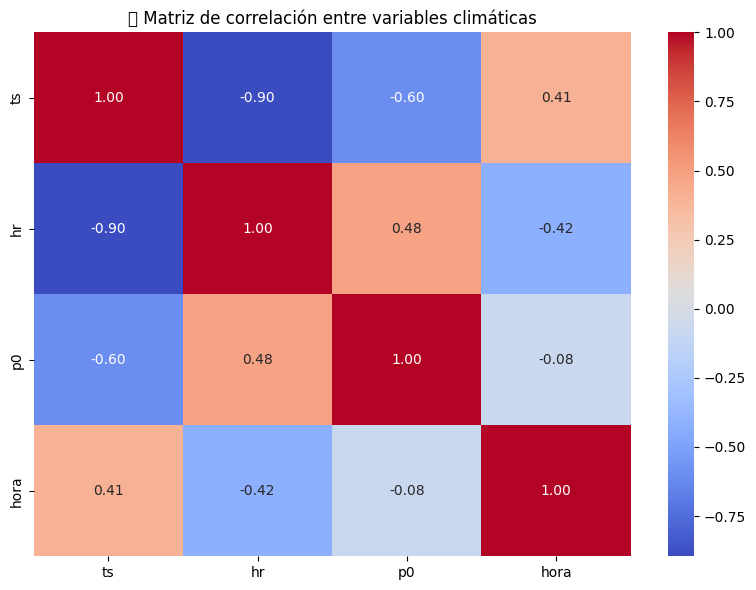

✅ Escalado completado y guardado: scaler_ligero.pkl


In [12]:
#=== Matriz de correlación ===

plt.figure(figsize=(8, 6))
sns.heatmap(df_selected.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("🔗 Matriz de correlación entre variables climáticas")
plt.tight_layout()
plt.show()

#=== Escalado ===

scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_selected)
scaler_path = "scaler_ligero.pkl"
joblib.dump(scaler, scaler_path)
print(f"✅ Escalado completado y guardado: {scaler_path}")


In [13]:
#=== Crear secuencias ===

def crear_secuencias(datos, pasos=24, col_obj=0):
  X, y = [], []
  for i in range(pasos, len(datos)):
    X.append(datos[i-pasos:i])
    y.append(datos[i, col_obj])
  return np.array(X), np.array(y)

n_pasos = 24
X, y = crear_secuencias(data_scaled, pasos=n_pasos, col_obj=0)
print(f"✅ Secuencias creadas: X={X.shape}, y={y.shape}")

✅ Secuencias creadas: X=(59136, 24, 4), y=(59136,)


In [14]:
#=== División 60% / 20% / 20% ===

n_total = len(X)
n_train = int(n_total * 0.6)
n_val = int(n_total * 0.2)

X_train, y_train = X[:n_train], y[:n_train]
X_val, y_val = X[n_train:n_train+n_val], y[n_train:n_train+n_val]
X_test, y_test = X[n_train+n_val:], y[n_train+n_val:]

print(f"✅ División de datos:")
print(f" Entrenamiento: {len(X_train)}")
print(f" Validación: {len(X_val)}")
print(f" Prueba: {len(X_test)}")

✅ División de datos:
 Entrenamiento: 35481
 Validación: 11827
 Prueba: 11828


In [15]:
# === Modelo LSTM liviano (2 capas LSTM) ===
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(n_pasos, X.shape[2]), activation='tanh'),
    Dropout(0.2),
    LSTM(32, activation='tanh'),
    Dropout(0.1),
    Dense(8, activation='relu'),
    Dense(1)
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='mse', metrics=['mae'])
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 24, 64)         │        17,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,353 (118.57 KB)

 Trainable params: 30,353 (118.57 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
#=== Callbacks ===

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
checkpoint = ModelCheckpoint("modelo_clima_best.h5", save_best_only=True)

#=== Entrenamiento ===

history = model.fit(
X_train, y_train,
validation_data=(X_val, y_val),
epochs=40,
batch_size=32,
callbacks=[early_stop, checkpoint],
verbose=1
)

Epoch 1/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.1386 - mae: 0.2559

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 25s 20ms/step - loss: 0.1385 - mae: 0.2558 - val_loss: 0.0181 - val_mae: 0.1022
Epoch 2/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0253 - mae: 0.1222

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0253 - mae: 0.1222 - val_loss: 0.0115 - val_mae: 0.0803
Epoch 3/40
1108/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0192 - mae: 0.1057

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 22s 20ms/step - loss: 0.0192 - mae: 0.1057 - val_loss: 0.0098 - val_mae: 0.0752
Epoch 4/40
1107/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0148 - mae: 0.0925

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - loss: 0.0148 - mae: 0.0925 - val_loss: 0.0074 - val_mae: 0.0634
Epoch 5/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0134 - mae: 0.0874

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0134 - mae: 0.0874 - val_loss: 0.0067 - val_mae: 0.0593
Epoch 6/40
1108/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0123 - mae: 0.0836

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0123 - mae: 0.0836 - val_loss: 0.0063 - val_mae: 0.0576
Epoch 7/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0115 - mae: 0.0814 - val_loss: 0.0069 - val_mae: 0.0607
Epoch 8/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0109 - mae: 0.0789 - val_loss: 0.0070 - val_mae: 0.0622
Epoch 9/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0101 - mae: 0.0762 - val_loss: 0.0065 - val_mae: 0.0598
Epoch 10/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0098 - mae: 0.0746 - val_loss: 0.0071 - val_mae: 0.0634
Epoch 11/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - loss: 0.0094 - mae: 0.0738 - val_loss: 0.0066 - val_mae: 0.0597
Epoch 12/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.0094 - mae: 0.0734

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0094 - mae: 0.0734 - val_loss: 0.0060 - val_mae: 0.0553
Epoch 13/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - loss: 0.0092 - mae: 0.0725 - val_loss: 0.0073 - val_mae: 0.0634
Epoch 14/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 19s 17ms/step - loss: 0.0087 - mae: 0.0706 - val_loss: 0.0083 - val_mae: 0.0698
Epoch 15/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - loss: 0.0087 - mae: 0.0706 - val_loss: 0.0063 - val_mae: 0.0582
Epoch 16/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0085 - mae: 0.0690

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0085 - mae: 0.0690 - val_loss: 0.0059 - val_mae: 0.0564
Epoch 17/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0080 - mae: 0.0678 - val_loss: 0.0061 - val_mae: 0.0581
Epoch 18/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0079 - mae: 0.0673

1109/1109 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0079 - mae: 0.0673 - val_loss: 0.0058 - val_mae: 0.0555
Epoch 19/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 0.0079 - mae: 0.0672 - val_loss: 0.0078 - val_mae: 0.0650
Epoch 20/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0078 - mae: 0.0667 - val_loss: 0.0060 - val_mae: 0.0572
Epoch 21/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0076 - mae: 0.0656 - val_loss: 0.0073 - val_mae: 0.0650
Epoch 22/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0076 - mae: 0.0655 - val_loss: 0.0076 - val_mae: 0.0664
Epoch 23/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 18s 17ms/step - loss: 0.0075 - mae: 0.0654 - val_loss: 0.0067 - val_mae: 0.0600
Epoch 24/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0073 - mae: 0.0649 - val_loss: 0.0060 - val_mae: 0.0570
Epoch 25/40
1109/1109 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 0.0074 - mae: 0.0647 - val_loss: 0.0083 - val_mae: 0.0702
Epoch 26/40
1109/1109 ━━━━━━

In [17]:
#=== Evaluar en test ===

loss, mae = model.evaluate(X_test, y_test, verbose=0)
print(f"\n📊 RESULTADOS FINAL:")
print(f" MSE: {loss:.4f} | MAE: {mae:.4f}")


📊 RESULTADOS FINAL:
 MSE: 0.0106 | MAE: 0.0793


In [18]:
#=== Guardar modelo ===

model.save("modelo_clima_ligero.h5")
print("💾 Modelo guardado: modelo_clima_ligero.h5")

💾 Modelo guardado: modelo_clima_ligero.h5


In [19]:
#==================================================
#CONVERSIÓN A TENSORFLOW LITE
#==================================================

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
tf.lite.OpsSet.TFLITE_BUILTINS,
tf.lite.OpsSet.SELECT_TF_OPS
]
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model = converter.convert()
with open("modelo_clima_ligero.tflite", "wb") as f:
  f.write(tflite_model)
print("💡 Conversión exitosa → modelo_clima_ligero.tflite")

#=== Cuantización FP16 (opcional) ===

converter.target_spec.supported_types = [tf.float16]
tflite_model_fp16 = converter.convert()
with open("modelo_clima_ligero_fp16.tflite", "wb") as f:
  f.write(tflite_model_fp16)
print("✅ Modelo cuantizado FP16 guardado (para Raspberry Pi)")

Saved artifact at '/tmp/tmp26sp_oew'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 24, 4), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  139539123495056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139539123499664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139539123499472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139539123501584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139539123502160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139539123500816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139539123501776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139539123501008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139539123500624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139539123501200: TensorSpec(shape=(), dtype=tf.resource, name=None)
💡 Conversión exitosa →

370/370 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step

📈 MÉTRICAS EN ESCALA REAL:
 - MAE: 0.618
 - MSE: 0.643
 - R²: 0.989
 - Confianza: 98.9%


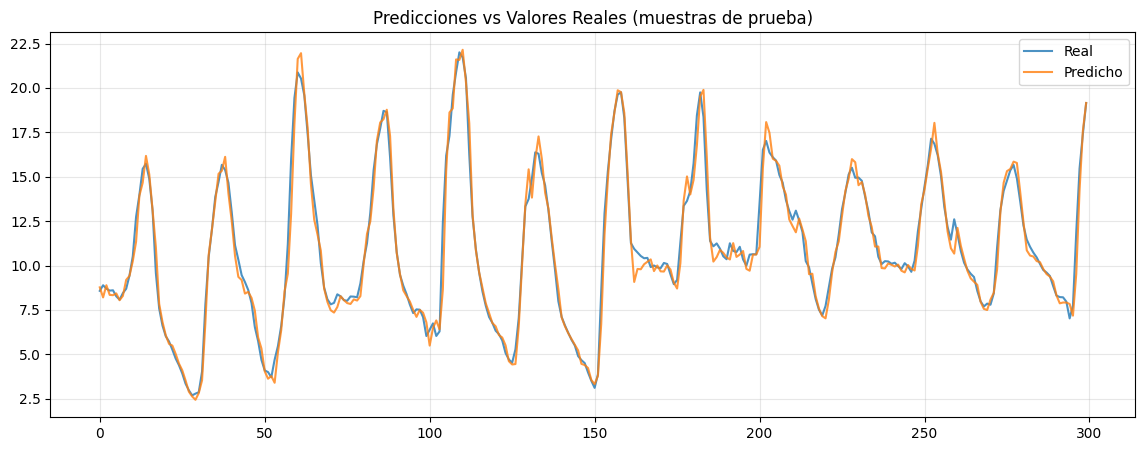

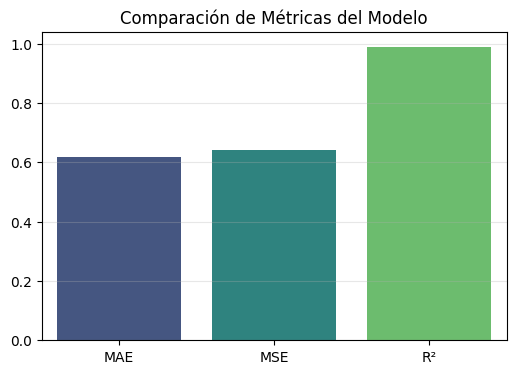

In [20]:
#==================================================
#EVALUACIÓN COMPLETA (MAE, MSE, R², confianza)
#==================================================

y_pred_scaled = model.predict(X_test)
dummy_pred = np.zeros((len(y_pred_scaled), data_scaled.shape[1]))
dummy_pred[:, 0] = y_pred_scaled.flatten()
y_pred_real = scaler.inverse_transform(dummy_pred)[:, 0]

dummy_true = np.zeros((len(y_test), data_scaled.shape[1]))
dummy_true[:, 0] = y_test
y_true_real = scaler.inverse_transform(dummy_true)[:, 0]

mae_real = mean_absolute_error(y_true_real, y_pred_real)
mse_real = mean_squared_error(y_true_real, y_pred_real)
r2 = r2_score(y_true_real, y_pred_real)
confianza = max(0, min(100, r2 * 100))

print("\n📈 MÉTRICAS EN ESCALA REAL:")
print(f" - MAE: {mae_real:.3f}")
print(f" - MSE: {mse_real:.3f}")
print(f" - R²: {r2:.3f}")
print(f" - Confianza: {confianza:.1f}%")

#=== Gráficos ===

plt.figure(figsize=(14, 5))
plt.plot(y_true_real[:300], label="Real", alpha=0.8)
plt.plot(y_pred_real[:300], label="Predicho", alpha=0.8)
plt.title("Predicciones vs Valores Reales (muestras de prueba)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

#--- Gráfico de métricas ---

metricas = {"MAE": mae_real, "MSE": mse_real, "R²": r2}
plt.figure(figsize=(6, 4))
sns.barplot(x=list(metricas.keys()), y=list(metricas.values()), palette="viridis")
plt.title("Comparación de Métricas del Modelo")
plt.grid(axis='y', alpha=0.3)
plt.show()

In [21]:
#==================================================
#GUARDAR MODELO FINAL Y RESUMEN
#==================================================

model_path = "modelo_lstm_3_features.h5"
model.save(model_path)

print(f"\n✅ ARCHIVOS GUARDADOS:")
print(f" 📦 Modelo: {model_path}")
print(f" 📦 Scaler: {scaler_path}")
print(f"\n🎉 ¡Entrenamiento completado exitosamente!")
print(f"\n📝 Configuración del modelo:")
print(f" - Dataset: dataset_ml.csv")
print(f" - Features: 3 columnas (ts, hr, p0)")
print(f" - Timesteps: {n_pasos}")
print(f" - MAE: {mae_real:.3f} °C")
print(f" - Objetivo: Predecir 'ts' (Temperatura del Aire Seco)")
print(f" - Confianza: {confianza:.1f}%")
print(f"\n💡 Ahora puedes usar el modelo con 'predecir_simple.py'")


✅ ARCHIVOS GUARDADOS:
 📦 Modelo: modelo_lstm_3_features.h5
 📦 Scaler: scaler_ligero.pkl

🎉 ¡Entrenamiento completado exitosamente!

📝 Configuración del modelo:
 - Dataset: dataset_ml.csv
 - Features: 3 columnas (ts, hr, p0)
 - Timesteps: 24
 - MAE: 0.618 °C
 - Objetivo: Predecir 'ts' (Temperatura del Aire Seco)
 - Confianza: 98.9%

💡 Ahora puedes usar el modelo con 'predecir_simple.py'
